In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

SMALL_SIZE = 25
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE +2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Constants
D_rho = 2.2e-5  # kg/ms
R = 8.314  # J/K*mol
dM = 0.003  # kg/mol
M = 0.352  # kg/mol of UF6
M_atm = 0.238  # atomic mass of natural uranium

# Centrifuge assumptions
x = 1000  # pressure ratio (Glaser)
k = 2.0  # L/F ratio

# Centrifuge parameters
# v_a = 485.0 # m/s
# Z = 1.0   # m
# d = 0.15  # m
# F_m = 15e-6 # kg/s (paper is in mg/s)
#r_12 = 0.746


def calc_del_U(cut):
    
    Z = 0.5
    d = 0.15
    v_a = 485.0
    F_m = 15.0*1e-6
    T = 320.0
    eff = 1.0
    verbose=False
    a = d / 2.0  # outer radius
    r_2 = 0.975 * a  # fraction of a

    # Intermediate calculations
    r_12 = np.sqrt(1.0 - (2.0 * R * T * (np.log(x)) / M / (v_a**2)))  # fraction
    r_1 = r_2 * r_12  # fraction

    # Glaser eqn 12
    L_F = k  # range 2-4
    Z_p = Z * (1.0 - cut) * (1.0 + L_F) / (1.0 - cut + L_F)

    if (verbose == True):
        print("L_F= ", L_F)
        print("Z_p=  ", Z_p)
        print("r_1", r_1)
        print("r_12", r_12)

    # Glaser eqn 3
    # To convert from gas to atom fraction, multiple by M_atm/M
    C1 = (2.0 * np.pi * (D_rho * M_atm / M) / (np.log(r_2 / r_1)))
#    C1 = (2.0*np.pi*(D_rho)/(np.log(r_2/r_1)))
    A_p = C1 * (1.0 / F_m) * (cut / ((1.0 + L_F) * (1.0 - cut + L_F)))
    A_w = C1 * (1.0 / F_m) * ((1.0 - cut) / (L_F * (1.0 - cut + L_F)))

    C_flow = 0.5 * F_m * cut * (1.0 - cut)
    C_therm = calc_C_therm(v_a, T)

    C_scale = ((r_2 / a)**4) * ((1 - (r_12**2))**2)
    bracket1 = (1 + L_F) / cut
    exp1 = np.exp(-1.0 * A_p * Z_p)
    bracket2 = L_F / (1 - cut)
    exp2 = np.exp(-1.0 * A_w * (Z - Z_p))

    # Glaser eqn 10
    # Efficiency applied to optimal del_U in Ratz p73 (pdf p21)
    major_term = 0.5 * cut * (1.0 - cut) * (C_therm**2) * C_scale * (
        (bracket1 * (1 - exp1)) + (bracket2 * (1 - exp2)))**2  # kg/s
    del_U = F_m * major_term * eff  # kg/s

    per_sec2yr = 60 * 60 * 24 * 365.25  # s/m * m/hr * hr/d * d/y

    # Glaser eqn 6
    dirac = 0.5 * np.pi * Z * (D_rho * M_atm / M) * \
        (C_therm**2) * per_sec2yr  # kg/s
    del_U_yr = del_U * per_sec2yr

    # Avery p.18
    #alpha = alpha_by_swu(del_U, F_m, cut)

    return del_U#, del_U_yr, dirac  # kg/sec

# for a machine


def calc_C_therm(v_a, T):
    C_therm = (dM * (v_a**2)) / (2.0 * R * T)
    return C_therm


def calc_V(N_in):
    V_out = (2.0 * N_in - 1.0) * np.log(N_in / (1.0 - N_in))
    return V_out


def alpha_by_swu(cut):
    # avery p.18
    # del_u in moles/sec
    F_m = 15.0*1e-6

    del_u_moles = calc_del_U(cut) / M
    alpha = 1 + np.sqrt((2 * del_u_moles * (1 - cut) / (cut * F_m)))
    return alpha

    

In [5]:
alpha_by_swu(0.5)

1.163210314314844

In [6]:
calc_del_U(0.5)

7.032328168470047e-08

In [7]:
def nprime_by_alpha(alpha, N):
    return alpha*N/(1-N+alpha*N)

def nsecond_by_cut(cut, N_prime, N):
    return(N - cut*N_prime)/(1-cut)

def R_(N):
    return N/(1-N)

def beta_by_alpha(cut, N):
    alpha = alpha_by_swu(cut)
    N_prime = nprime_by_alpha(alpha, N)
    N_second = nsecond_by_cut(cut, N_prime, N)
    beta = R_(N)/R_(N_second)
    return beta


from scipy import optimize as opt

def a_b_zero(N):
    def func(x):
        return alpha_by_swu(x) - beta_by_alpha(x,N)
    
    a =(opt.fsolve( func, 0.5))
    return a

In [8]:
print(a_b_zero(0.035))

[0.46278944]


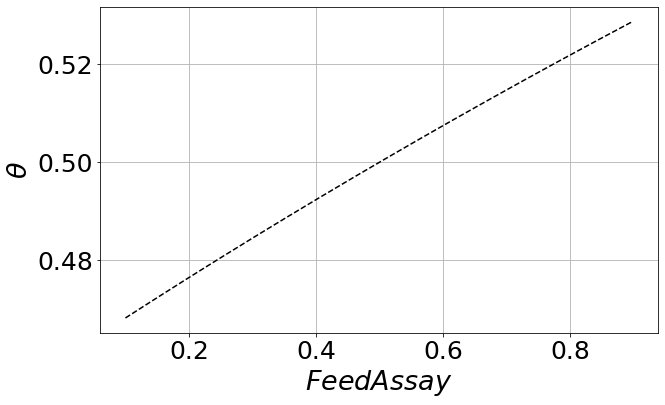

In [9]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.1, 0.9, 0.001)
y = [a_b_zero(v) for v in t]

plt.grid()
plt.plot(t, y, 'k--')
plt.ylabel(r'${\theta}$')
plt.xlabel(r'${Feed Assay}$')


#plt.legend()
#plt.savefig(filename="test.png")
plt.show()

In [10]:
alpha_by_swu(0.5)

1.163210314314844

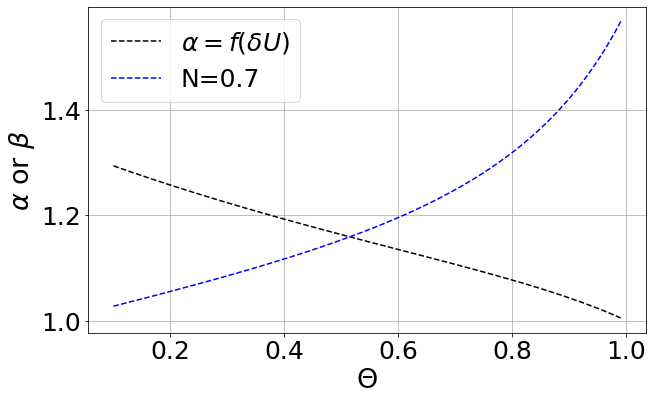

In [12]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.1, 1.0, 0.01)

plt.plot(t, alpha_by_swu(t), 'k--', label=r'${\alpha = f(\delta U)}$')
#plt.plot(t, beta_by_alpha(t, 0.02), 'r--', label='N=0.07')
plt.plot(t, beta_by_alpha(t, 0.7), 'b--', label='N=0.7')

plt.ylabel(r'${\alpha}$ or ${\beta}$')
plt.xlabel(r'${\Theta}$')
plt.grid()



plt.legend()

plt.savefig(fname="alpha_vs_beta.png")



plt.show()

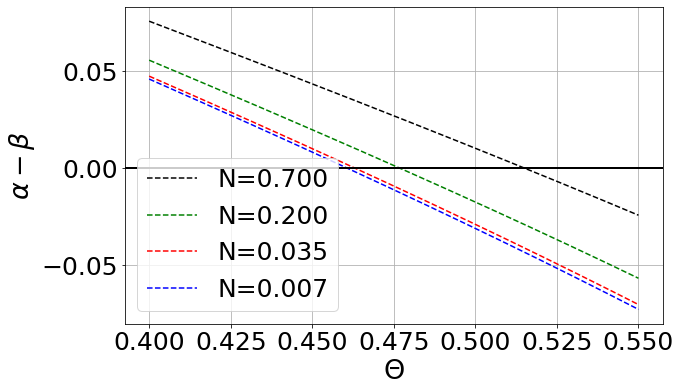

In [14]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.40, 0.55, 0.0001)

plt.grid()
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.7), 'k--', label='N=0.700')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.200), 'g--', label='N=0.200')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.035), 'r--', label='N=0.035')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.007), 'b--', label='N=0.007')
#plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.003), 'g--', label='N=0.003')
plt.axhline(y=0.0, xmin=0, xmax = 1, linewidth=2, color='k')
plt.ylabel(r'${\alpha-\beta}$')
plt.xlabel(r'${\Theta}$')
plt.legend()
plt.tight_layout()
plt.savefig(fname="alpha_minus_beta.png", bbox_inches='tight')
plt.show()

In [ ]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.4, 0.75, 0.0001)

plt.grid()
plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.035), 'r--', label='N=0.035')
plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.7), 'b--', label='N=0.7')

plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.5), 'k--', label='N=0.5')

plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.072), 'g--', label='N=0.0072')
plt.axhline(y=alpha_by_swu(0.46)*beta_by_alpha(0.46, 0.0072), xmin=0, xmax = 1, linewidth=2, color='k', label=r'$N=0.0072/\theta $=0.46')
plt.axvline(x=0.4627894390421519)
plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${\Theta}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()

In [13]:
def P_by_gamma_plus(gamma, F, theta):
    P = 1. / (2. * (gamma - 1.) * theta) 
    P *= (sqrt(pow((F-theta)*gamma,2) 
                  + (2*F+2*theta - 2*F*F - 2*theta*theta)*gamma 
                  + pow(F+theta -1, 2) )
             + (F+theta)*gamma - F - theta +1)
    return P

def P_by_gamma_minus(gamma, F, theta):
    P = 1. / (2. * (gamma - 1.) * theta) 
    P *= (-sqrt(pow((F-theta)*gamma,2) 
                  + (2.*F + 2.*theta - 2.*F*F - 2.*theta*theta)*gamma 
                  + pow(F + theta - 1., 2) ) 
             + (F + theta)*gamma - F - theta + 1.)
    return P

In [14]:

theta_ = 0.46040372309
print(alpha_by_swu(theta_))
print(beta_by_alpha(theta_, 0.007))

NameError: name 'alpha_by_swu' is not defined

In [15]:
def leveling_by_gamma(gamma, F, theta, level):
    for i in range(level):
        F = P_by_gamma_minus(gamma, F, theta)
    return F

In [16]:
alpha_ = alpha_by_swu(theta_)
F = 0.007
R_P = F/(1-F)*alpha_
P = R_P/(1+R_P)
print(P)

NameError: name 'alpha_by_swu' is not defined

In [28]:
gamma_ = 1.1746623368715323*1.1746623368719693
print("gamma", gamma_)
theta_ = 0.46040372309
print("1 level: ", P_by_gamma_minus(gamma_, 0.007, theta_))
print("10 level: ", leveling_by_gamma(gamma_, 0.007, theta_, 11))



gamma 1.3798316056650026
1 level:  0.008212595340443064
10 level:  0.03988598004371069


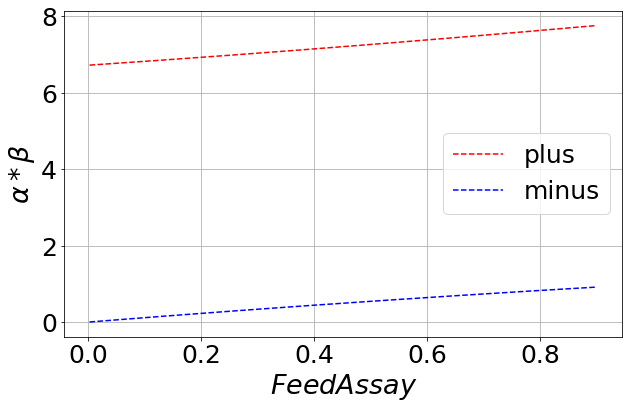

In [29]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.002, 0.9, 0.00001)

plt.grid()
plt.plot(t, P_by_gamma_plus(gamma_, t, theta_), 'r--', label='plus')
plt.plot(t, P_by_gamma_minus(gamma_, t, theta_), 'b--', label='minus')


plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${Feed Assay}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()

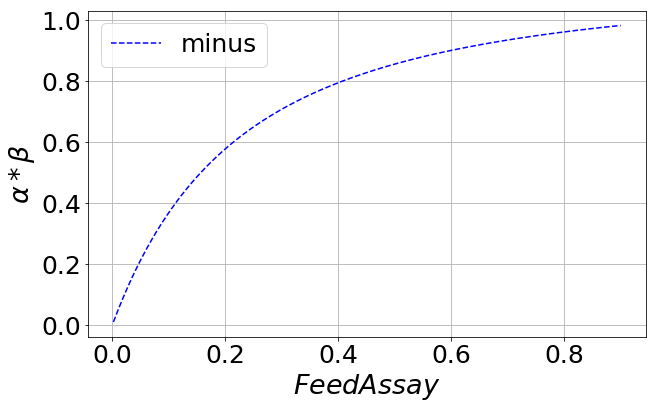

In [30]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.002, 0.9, 0.00001)

plt.grid()
#plt.plot(t, P_by_gamma_plus(gamma_, t, theta_), 'r--', label='plus')
plt.plot(t, leveling_by_gamma(gamma_, t, theta_, 10), 'b--', label='minus')


plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${Feed Assay}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()

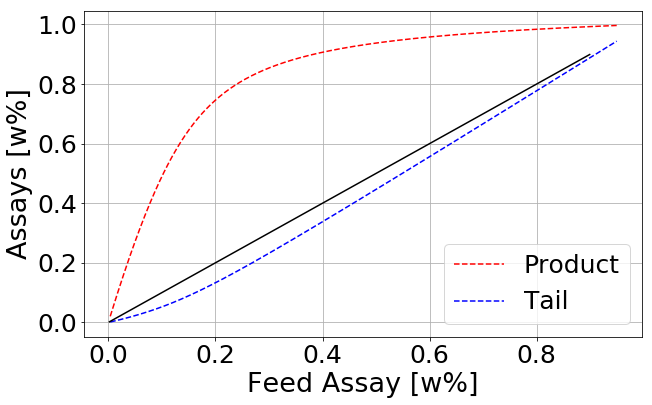

In [31]:
model_0 = np.loadtxt("model_0.dat")
feed_assay = [v[0] for v in model_0]
product_assay_0 = [v[1] for v in model_0]
tail_assay_0 = [v[2] for v in model_0]
t = np.arange(0.002, 0.9, 0.001)


plt.grid()
plt.plot(feed_assay, product_assay_0, 'r--', label='Product')
plt.plot(feed_assay, tail_assay_0, 'b--', label='Tail')
plt.plot(t, t, 'k')



plt.ylabel("Assays [w%]")
plt.xlabel("Feed Assay [w%]")


plt.legend()


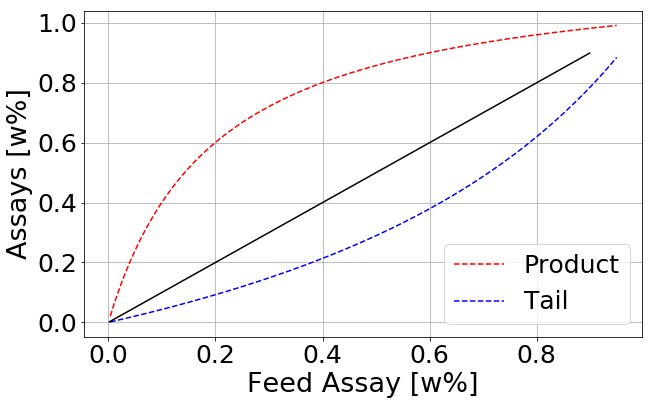

In [32]:
model_1 = np.loadtxt("model_1.dat")
feed_assay = [v[0] for v in model_1]
product_assay_1 = [v[1] for v in model_1]
tail_assay_1 = [v[2] for v in model_1]
t = np.arange(0.002, 0.9, 0.001)


plt.grid()
plt.plot(feed_assay, product_assay_1, 'r--', label='Product')
plt.plot(feed_assay, tail_assay_1, 'b--', label='Tail')
plt.plot(t, t, 'k')



plt.ylabel("Assays [w%]")
plt.xlabel("Feed Assay [w%]")


plt.legend()

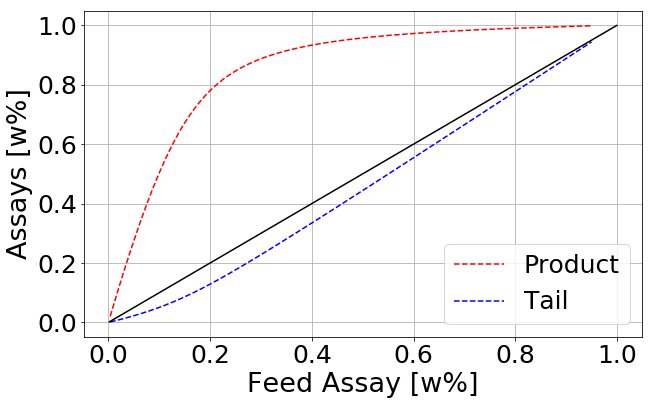

In [33]:
model_2 = np.loadtxt("model_2.dat")
feed_assay = [v[0] for v in model_2]
product_assay_2 = [v[1] for v in model_2]
tail_assay_2 = [v[2] for v in model_2]
t = np.arange(0.002, 1, 0.001)


plt.grid()
plt.plot(feed_assay, product_assay_2, 'r--', label='Product')
plt.plot(feed_assay, tail_assay_2, 'b--', label='Tail')
plt.plot(t, t, 'k')



plt.ylabel("Assays [w%]")
plt.xlabel("Feed Assay [w%]")


plt.legend()

Lvl 0:
0.007   0.0407063
0.0407063   0.2249585883
0.2249585883   0.7816388273772
0.7816388273772   0.9819422992198517

Lvl 1:
0.007   0.0407157
0.0407157   0.2035632137
0.2035632137   0.6061718609253001
0.6061718609253001   0.9026189166814357

Lvl 2:
0.007   0.040705700000000004
0.040705700000000004   0.2268747193
0.2268747193   0.8195770154233
0.8195770154233   0.9909357749562446


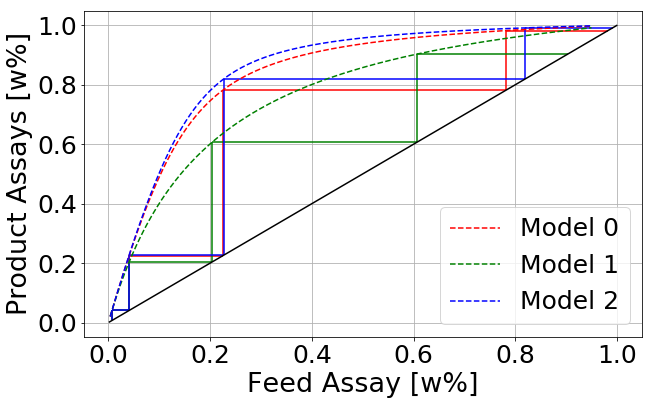

In [34]:
fig, ax = plt.subplots()
ax.grid()



ax.plot(feed_assay, product_assay_0, 'r--', label='Model 0')
ax.plot(feed_assay, product_assay_1, 'g--', label='Model 1')
ax.plot(feed_assay, product_assay_2, 'b--', label='Model 2')
ax.plot(t, t, 'k')

plt.ylabel("Product Assays [w%]")
plt.xlabel("Feed Assay [w%]")

print("Lvl 0:")
val_feed = 0.007
while val_feed < 0.9 :
    val_prod = np.interp(val_feed, feed_assay, product_assay_0)
    print(val_feed, " ", val_prod)
    ax.vlines(x=val_feed, ymin = val_feed, ymax = val_prod, color='r')
    ax.hlines(y=val_prod, xmin = val_feed, xmax = val_prod, color='r')
    val_feed = val_prod

print("\nLvl 1:")    
val_feed = 0.007
while val_feed < 0.9 :
    val_prod = np.interp(val_feed, feed_assay, product_assay_1)
    print(val_feed, " ", val_prod)
    ax.vlines(x=val_feed, ymin = val_feed, ymax = val_prod, color='g')
    ax.hlines(y=val_prod, xmin = val_feed, xmax = val_prod, color='g')
    val_feed = val_prod

print("\nLvl 2:")    
val_feed = 0.007
while val_feed < 0.9 :
    val_prod = np.interp(val_feed, feed_assay, product_assay_2)
    print(val_feed, " ", val_prod)
    ax.vlines(x=val_feed, ymin = val_feed, ymax = val_prod, color='b')
    ax.hlines(y=val_prod, xmin = val_feed, xmax = val_prod, color='b')
    val_feed = val_prod



plt.legend()

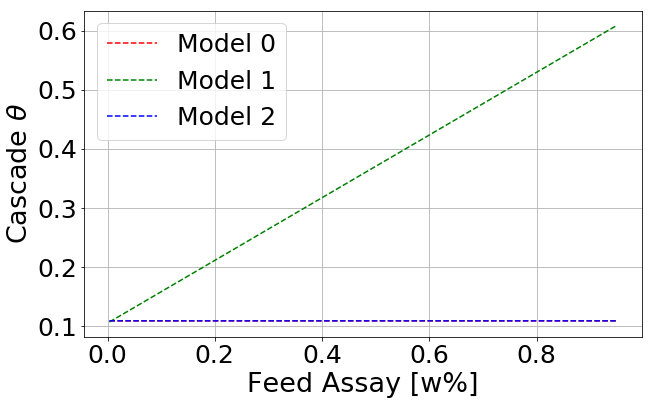

In [35]:
fig, ax = plt.subplots()
ax.grid()

theta_0 = [(v[0]-v[2])/(v[1]-v[2]) for v in model_0]
theta_1 = [(v[0]-v[2])/(v[1]-v[2]) for v in model_1]
theta_2 = [(v[0]-v[2])/(v[1]-v[2]) for v in model_2]


ax.plot(feed_assay, theta_0, 'r--', label='Model 0')
ax.plot(feed_assay, theta_1, 'g--', label='Model 1')
ax.plot(feed_assay, theta_2, 'b--', label='Model 2')
#ax.plot(feed_assay, product_assay_1, 'g--', label='Model 1')
#ax.plot(feed_assay, product_assay_2, 'b--', label='Model 2')
#ax.plot(t, t, 'k')

plt.ylabel("Cascade " + r'${\theta}$')
plt.xlabel("Feed Assay [w%]")

plt.legend()

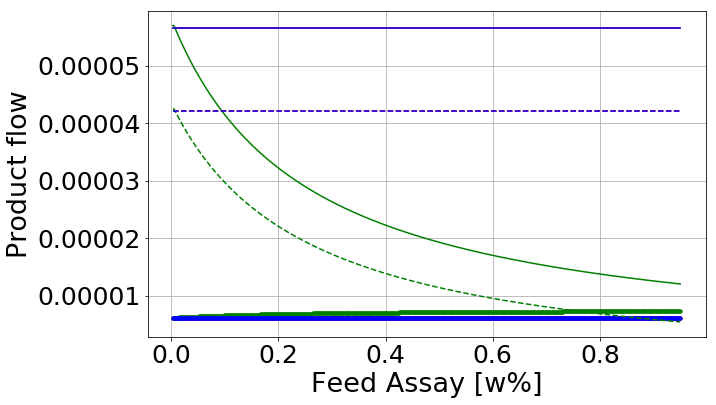

In [36]:
fig, ax = plt.subplots()
ax.grid()

feed_flow_0 = [v[3] for v in model_0]
feed_flow_1 = [v[3] for v in model_1]
feed_flow_2 = [v[3] for v in model_2]

prod_flow_0 = [v[4] for v in model_0]
prod_flow_1 = [v[4] for v in model_1]
prod_flow_2 = [v[4] for v in model_2]

tail_flow_0 = [v[5] for v in model_0]
tail_flow_1 = [v[5] for v in model_1]
tail_flow_2 = [v[5] for v in model_2]



ax.plot(feed_assay, feed_flow_0, 'r', label='feed 0')
ax.plot(feed_assay, feed_flow_1, 'g', label='Model 1')
ax.plot(feed_assay, feed_flow_2, 'b', label='Model 2')
ax.plot(feed_assay, prod_flow_0, 'r.', label='Model 0')
ax.plot(feed_assay, prod_flow_1, 'g.', label='Model 1')
ax.plot(feed_assay, prod_flow_2, 'b.', label='Model 2')
ax.plot(feed_assay, tail_flow_0, 'r--', label='Model 0')
ax.plot(feed_assay, tail_flow_1, 'g--', label='Model 1')
ax.plot(feed_assay, tail_flow_2, 'b--', label='Model 2')



plt.ylabel("Product flow")
plt.xlabel("Feed Assay [w%]")

#plt.legend()

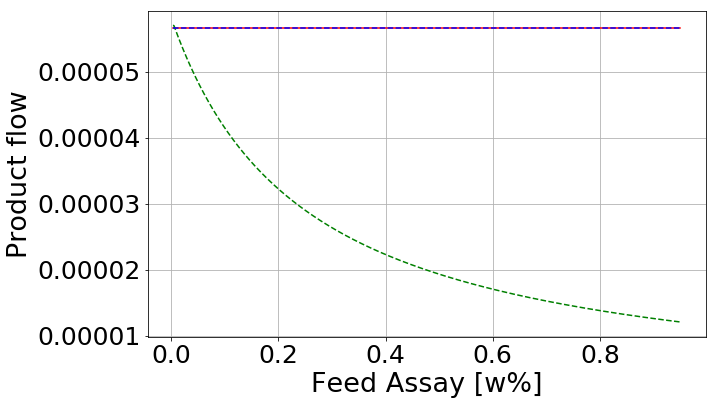

In [37]:
fig, ax = plt.subplots()
ax.grid()

ax.plot(feed_assay, feed_flow_0, 'r-', label='feed 0')
ax.plot(feed_assay, feed_flow_1, 'g--', label='Model 1')
ax.plot(feed_assay, feed_flow_2, 'b--', label='Model 2')



plt.ylabel("Product flow")
plt.xlabel("Feed Assay [w%]")

#plt.legend()

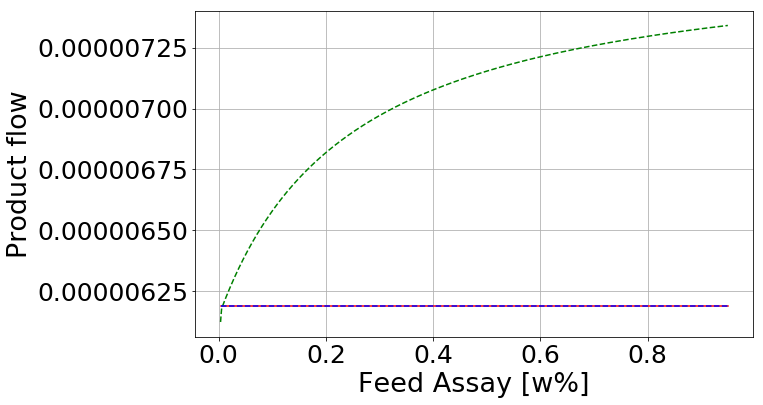

In [38]:
fig, ax = plt.subplots()
ax.grid()


ax.plot(feed_assay, prod_flow_0, 'r-', label='Model 0')
ax.plot(feed_assay, prod_flow_1, 'g--', label='Model 1')
ax.plot(feed_assay, prod_flow_2, 'b--', label='Model 2')



plt.ylabel("Product flow")
plt.xlabel("Feed Assay [w%]")

#plt.legend()

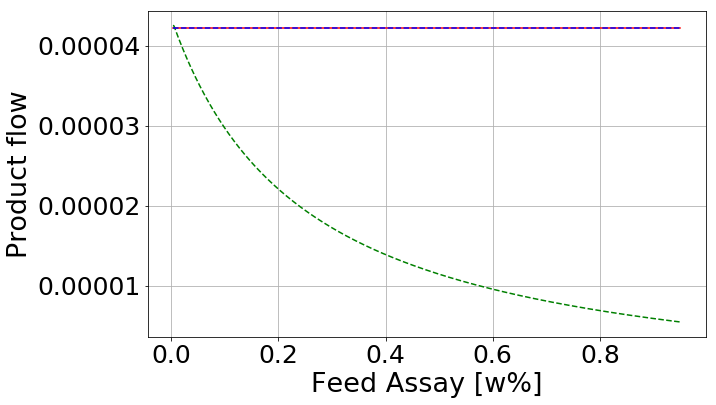

In [39]:
fig, ax = plt.subplots()
ax.grid()


ax.plot(feed_assay, tail_flow_0, 'r-', label='Model 0')
ax.plot(feed_assay, tail_flow_1, 'g--', label='Model 1')
ax.plot(feed_assay, tail_flow_2, 'b--', label='Model 2')



plt.ylabel("Product flow")
plt.xlabel("Feed Assay [w%]")

#plt.legend()

In [48]:
feed_flow_0 = [v[3] for v in model_0]
feed_flow_1 = [v[3] for v in model_1]
feed_flow_2 = [v[3] for v in model_2]




secpermonth = 2629846
assay_feed = 0.0071





print("Level 1")
assay_prod = np.interp(assay_feed, feed_assay, product_assay_0)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_0)*secpermonth*25
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_0)*secpermonth*25
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)

print("\nLevel 2")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_0)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_0)*secpermonth*3
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_0)*secpermonth*3*flow_prod/flow_feed
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)


print("\nLevel 3")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_0)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_0)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_0)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)


print("\nLevel 4")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_0)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_0)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_0)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)

print("\n Cyclus prod ", 6.373098)


Level 1
Assay  0.0071   0.04128226000000001
feed  44666.93496852
prod  4881.76998057

Level 2
Assay  0.04128226000000001   0.22791959866000003
feed  5360.032196222401
prod  533.5418281999944

Level 3
Assay  0.22791959866000003   0.7853939179236601
feed  1786.6773987408
prod  58.31222764939743

Level 4
Assay  0.7853939179236601   0.982329073546137
feed  1786.6773987408
prod  6.373100877407808

 Cyclus prod  6.373098


In [50]:
secpermonth = 2629846
assay_feed = 0.0071

print("Level 1")
assay_prod = np.interp(assay_feed, feed_assay, product_assay_1)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_1)*secpermonth*25
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_1)*secpermonth*25
print("feed ", flow_feed/25.)
print("prod ", flow_prod*12)

print("\nLevel 2")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_1)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_1)*secpermonth*3
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_1)*secpermonth*3/flow_feed*flow_prod
print("feed ", flow_feed/3)
print("prod ", flow_prod*12)


print("\nLevel 3")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_1)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_1)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_1)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed)
print("prod ", flow_prod*12)


print("\nLevel 4")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_1)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_1)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_1)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed)
print("prod ", flow_prod*12)
print("\n Cyclus prod ", 55.408299)





Level 1
Assay  0.0071   0.04127770000000001
feed  148.89041439144
prod  4881.7668247548

Level 2
Assay  0.04127770000000001   0.2058904557
feed  131.2988371410068
prod  621.964099270933

Level 3
Assay  0.2058904557   0.6095781130435001
feed  83.68019822370637
prod  133.5019800891235

Level 4
Assay  0.6095781130435001   0.9038675112608775
feed  44.28915491961007
prod  57.21760524870817

 Cyclus prod  55.408299


In [49]:
feed_flow_2 = [v[3] for v in model_2]
feed_flow_2 = [v[3] for v in model_2]
feed_flow_2 = [v[3] for v in model_2]




secpermonth = 2629846
assay_feed = 0.0071


print("Level 1")
assay_prod = np.interp(assay_feed, feed_assay, product_assay_2)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_2)*secpermonth*25
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_2)*secpermonth*25
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)

print("\nLevel 2")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_2)
print("Assay ", assay_feed, " ", assay_prod)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_2)*secpermonth*3
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_2)*secpermonth*3*flow_prod/flow_feed
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)


print("\nLevel 3")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_2)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_2)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_2)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)


print("\nLevel 4")
assay_feed = assay_prod
assay_prod = np.interp(assay_feed, feed_assay, product_assay_2)
flow_feed = np.interp(assay_feed, feed_assay, feed_flow_2)*secpermonth
flow_prod = np.interp(assay_feed, feed_assay, prod_flow_2)*secpermonth/flow_feed*flow_prod
print("Assay ", assay_feed, " ", assay_prod)
print("feed ", flow_feed*12)
print("prod ", flow_prod*12)

print("\n Cyclus prod ", 6.373098)




Level 1
Assay  0.0071   0.041282540000000006
feed  148.8897832284
prod  4881.76998057

Level 2
Assay  0.041282540000000006   0.22990255246000002
feed  148.8897832284
prod  533.5418281999944

Level 3
Assay  0.22990255246000002   0.8234027752602401
feed  148.8897832284
prod  58.31222764939743

Level 4
Assay  0.8234027752602401   0.9911700692908746
feed  148.8897832284
prod  6.373100877407808

 Cyclus prod  6.373098


In [43]:
7.683002326079919/6.373098

1.2055365108272176

In [44]:
53.64168045911653/55.408299

0.9681163549004912